In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
random.seed(2147483647)
random.shuffle(words)
n = len(words)

n_train = int(0.8 * n)
n_dev = int(0.1 * n)

words_train = words[:n_train]
words_dev = words[n_train:n_train + n_dev]
words_test = words[n_train + n_dev:]

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [3]:
def build_xy(words, stoi, block_size):
    x, y = [], []
    for w in words[:]:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(x), torch.tensor(y)
    return X, Y

def data_nll(X, Y, model):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        return loss.item()

def generate(itos, model, block_size, seed=2147483647, num_samples=5):
    with torch.no_grad():
        g = torch.Generator().manual_seed(seed)
        for i in range (num_samples):
            out = []
            context = [0] * block_size
            while True:
                probs = F.softmax(model(torch.tensor([context])), dim=1)
                ix = torch.multinomial(probs, num_samples=1, generator=g).item()
                context = context[1:] + [ix]
                if ix == 0:
                    break
                out.append(ix)
            print(''.join(itos[i] for i in out))

In [4]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
#-----------------------------------------------------------------------------------------------#
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        dim = None
        if self.training:
            if x.ndim == 2:
                dim = (0)
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
#-----------------------------------------------------------------------------------------------#
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
#-----------------------------------------------------------------------------------------------#
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
#-----------------------------------------------------------------------------------------------#
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
#-----------------------------------------------------------------------------------------------#
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [5]:
g = torch.Generator().manual_seed(2147483647)

In [6]:
block_size = 32

Xtr, Ytr = build_xy(words_train, stoi, block_size)
Xdev, Ydev = build_xy(words_dev, stoi, block_size)
Xte, Yte = build_xy(words_test, stoi, block_size)

In [7]:
n_embd = 32
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
lossi = []

144891


In [14]:
steps = 100000
batch_size = 128
for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    loss = F.cross_entropy(model(Xb), Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.0001 if i < 25000 else 0.00001 if i < 50000 else 0.000001
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i}/{steps}: {loss.item()}')
    lossi.append(loss.item())
    if i == 0:
        best_dev_loss = data_nll(Xdev, Ydev, model)
    if i % 1000 == 0 and i > 0 * steps:
        dev_loss = data_nll(Xdev, Ydev, model)
        if dev_loss <= best_dev_loss:
            min = dev_loss
        else:
            print(i)
            break

0/100000: 1.7000434398651123
1000


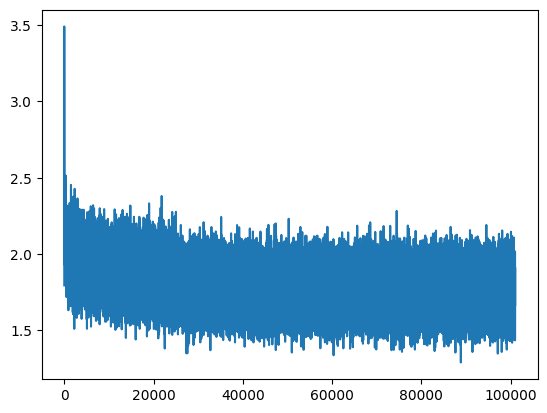

In [17]:
plt.plot(torch.tensor(lossi).view(-1, 1).mean(1))

In [18]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

print(data_nll(Xtr, Ytr, model))
print(data_nll(Xdev, Ydev, model))

1.755741834640503
2.049940586090088


Original (block_size = 3):

test:
2.0619866847991943

dev:
2.1212077140808105

Modified (block_size = 8):

test:
1.9272838830947876

dev:
2.0354456901550293

Flattened (block_size = 8):

test:
1.9598515033721924

dev:
2.039992094039917

Fixed BatchNorm1d (block_size = 8):

test:
1.9308412075042725

dev:
2.0306339263916016

Increased elements (block_size = 32):

test:
1.755741834640503

dev:
2.049940586090088

In [19]:
generate(itos, model, block_size)

cexie
mouhamik
carvin
kellie
janaiyah


In [20]:
print(data_nll(Xte, Yte, model))

2.049665689468384


Final Test Loss: 2.049665689468384